In [27]:
import  glob
import  fitsio
import  redrock
import  redrock.templates

import  pandas                 as      pd
import  pylab                  as      pl
import  numpy                  as      np
import  matplotlib.pyplot      as      plt
import  astropy.io.fits        as      fits
import  matplotlib.pyplot      as      plt

from    astropy.table          import  Table, join, vstack
from    astropy.coordinates    import  SkyCoord
from    astropy                import  units as u
from    desitarget.cmx         import  cmx_targetmask
from    desitarget             import  targetmask
from    desispec.interpolation import  resample_flux
from    desispec.resolution    import  Resolution
from    desispec.specscore     import  compute_frame_scores

In [2]:
##  DR7 cutouts
import requests

from   PIL                     import  Image
from   io                      import  BytesIO

In [3]:
plt.rcParams['figure.figsize'] = [10, 10]

In [4]:
%matplotlib inline

##  DR7 cutouts 

In [5]:
def get_dr7cutout(ra, dec):
  nim         = len(ra)
  nrow        =  np.maximum(np.floor(nim / 5).astype(np.int), 1)

  fig, axes   = plt.subplots(nrow, 5, figsize=(20, 5 * nrow))

  row         = 0
  col         = 0

  nmax        = np.minimum(5 * nrow, nim)
  
  for i in range(nmax):        
    url       = 'http://legacysurvey.org/viewer/jpeg-cutout?ra={:.4f}&dec={:.4f}&layer=decals-dr7&pixscale=0.27&bands=grz'.format(ra[i], dec[i])
    response  = requests.get(url)
    img       = Image.open(BytesIO(response.content))

    axes[row, col].imshow(img)
    
    col      += 1
    
    if col > 4:
        row  += 1
        col   = 0 

##  Night log.
http://desi-www.kpno.noao.edu:8090/nightsum/nightsum-2020-02-25/nightsum.html

##  Mini SV page.
https://desi.lbl.gov/trac/wiki/TargetSelectionWG/miniSV2

#  Summary 

In [6]:
# /global/homes/m/mjwilson/BGS/MINISV/zhou
root  = '/global/cscratch1/sd/mjwilson/BGS/MINISV/coadds/'

## Prep. redrock templates

In [7]:
templates = dict()

for filename in redrock.templates.find_templates():
    t = redrock.templates.Template(filename)
    templates[(t.template_type, t.sub_type)] = t

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


## GET GAMA G12 TRUTH TABLES

In [8]:
GAMA  = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/south/matched/GAMA-DR3-SpecObj-match.fits')
LGAMA = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/south/matched/ls-dr8.0-GAMA-DR3-SpecObj-match.fits')

In [9]:
# Table(LGAMA)

In [10]:
# Table(GAMA)

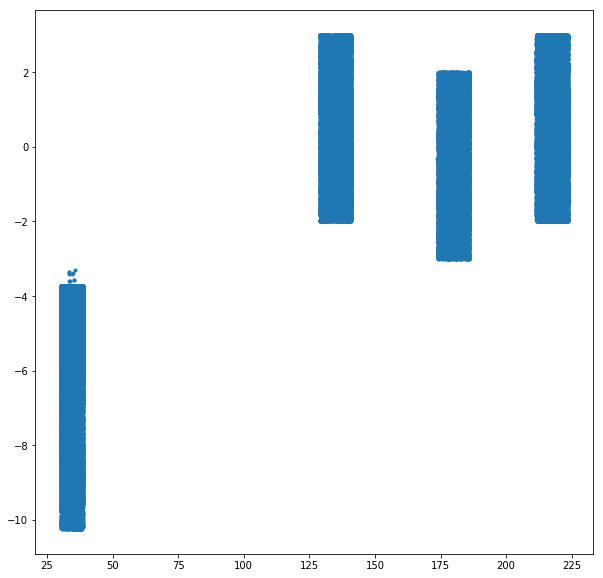

In [11]:
plt.rcParams['figure.figsize'] = [10, 10]

pl.plot(GAMA['RA'], GAMA['DEC'], '.')

In [12]:
##  Restrict to G12
isin   = (GAMA['RA'] < 200.) & (GAMA['RA'] > 150.)

G12    =  GAMA[isin]
LG12   =  LGAMA[isin]

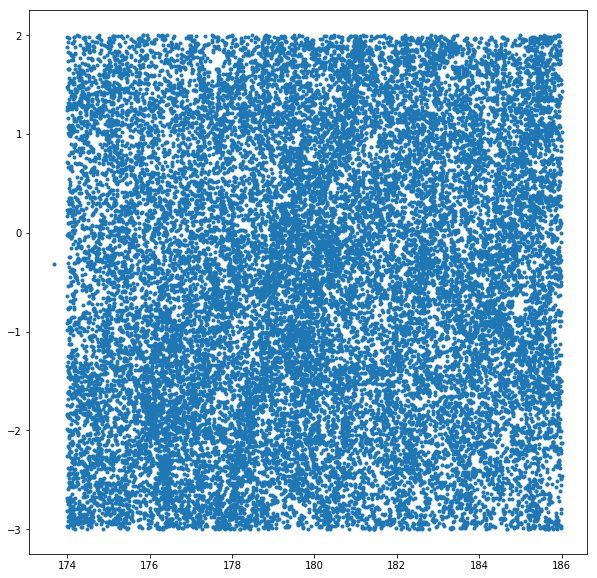

In [13]:
plt.rcParams['figure.figsize'] = [10, 10]

pl.plot(G12['RA'], G12['DEC'], '.')

##  GET SDSS redshifts  

In [16]:
SDSS  = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/south/matched/sdss-specObj-dr14-unique-trimmed-match.fits')
LSDSS = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/south/matched/ls-dr8.0-sdss-specObj-dr14-unique-trimmed-match.fits')

##  Rongpu cframe Table 

In [237]:
# ALL EXPIDS
cframes    = Table(fits.open('/global/homes/m/mjwilson/BGS/MINISV/zhou/bgs_allcframes.fits')[1].data)
del cframes['cframe']

# max_width=-1, max_lines=-1.
cframes.pprint()

 night        mjd         lat    ...        SUNDEC             SUNSEP      
-------- -------------- -------- ... ------------------- ------------------
20200303  58912.2806544 31.96403 ...  -6.234831481876057 121.58271161023774
20200303 58912.29681766 31.96403 ... -6.2285926614028195 121.56835734366216
20200303 58912.29681766 31.96403 ... -6.2285926614028195 121.56835734366216
20200303 58912.29681766 31.96403 ... -6.2285926614028195 121.56835734366216
20200303 58912.29018334 31.96403 ...  -6.231153192251106 121.57390223699986
20200303 58912.34548426 31.96403 ...  -6.209819807196399 121.52495589613204
20200303 58912.33885457 31.96403 ...  -6.212376125313928 121.53049579350501
20200303 58912.29018334 31.96403 ...  -6.231153192251106 121.57390223699986
20200303 58912.34548426 31.96403 ...  -6.209819807196399 121.52495589613204
20200228 58908.18319769 31.96403 ...  -7.802289556521098 124.95588876056017
     ...            ...      ... ...                 ...                ...
20200227 589

In [239]:
cframes    = cframes[cframes['night'] == '20200229']
cframes

night,mjd,lat,lon,elv,tileid,expid,exptime,camera,petal_loc,ra,dec,MOONALT,MOONRA,MOONDEC,MOONFRAC,MOONSEP,SUNALT,SUNRA,SUNDEC,SUNSEP
str8,float64,float64,float64,float64,int64,int64,float64,str1,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [107]:
# BGS EXPIDS
bgs_expids = cframes['expid']
nights     = cframes['night'] 
tiles      = cframes['tileid']
petals     = cframes['petal_loc']

##  Unique tiles and nights.

In [108]:
samples    = set(zip(nights, tiles))
samples

{('20200227', 70502), ('20200228', 70500), ('20200303', 70500)}

##  GET COORDINATES FILE FOR FIBER REACH ERRORS
https://desi.lbl.gov/trac/wiki/FPS/PositionerFlags

##  Missing coordinates files 

##  NUMBER OF FIBER REACH ERRORS FOR ALL TARGETS ON PLATE

##   GET COADDED EXPOSURES AND ZBEST FILES

In [20]:
# XTENSION= 'IMAGE   '           / Image extension                                
# BITPIX  =                  -32 / array data type                                
# NAXIS   =                    2 / number of array dimensions                     
# NAXIS1  =                 7781                                                  
# NAXIS2  =                  500                                                  
# PCOUNT  =                    0 / number of parameters                           
# GCOUNT  =                    1 / number of groups                               
# EXTNAME = 'BRZ_FLUX'           / extension name                                 
# BUNIT   = '10**-17 erg/(s cm2 Angstrom)'                                        
# CHECKSUM= '1gAq4f6n1fAn1f3n'   / HDU checksum updated 2020-02-26T06:51:09       
# DATASUM = '1442897442'         / data unit checksum updated 2020-02-26T06:51:09 

In [21]:
# XTENSION= 'IMAGE   '           / Image extension                                
# BITPIX  =                  -32 / array data type                                
# NAXIS   =                    2 / number of array dimensions                     
# NAXIS1  =                 7781                                                  
# NAXIS2  =                  500                                                  
# PCOUNT  =                    0 / number of parameters                           
# GCOUNT  =                    1 / number of groups                               
# EXTNAME = 'BRZ_IVAR'           / extension name                                 
# BUNIT   = '10**+34 (s2 cm4 Angstrom2) / erg2'                                   
# CHECKSUM= '4aSk6XPj4aPj4WPj'   / HDU checksum updated 2020-02-26T06:51:09       
# DATASUM = '966772586'          / data unit checksum updated 2020-02-26T06:51:09 

In [55]:
utiles    = np.unique(tiles)
upetals   = np.unique(petals)
unights   = np.unique(nights)

In [233]:
bandpasses                 = {"b": [4000, 5800], "r": [5800, 7600], "z": [7600, 9800]}

fpath                      = root + '/{}/{}/coadd-{}-{}-allexp.fits'.format(70500, '20200303', '20200303', 0)
wave                       = fitsio.read(fpath, ext=2)

results                    = {}

for tile in utiles:
    results[tile]          = {}

for i, (night, tile) in enumerate(samples):
      results[tile][night] = {}
        
      results[tile][night]['NEXP']          = len(np.unique(cframes[(cframes['night'] == night) & (cframes['tileid'] == tile)]['MOONDEC']))
      results[tile][night]['EXPTIME']       = results[tile][night]['NEXP'] * np.unique(cframes[(cframes['night'] == night) & (cframes['tileid'] == tile)]['exptime'])    
    
      results[tile][night]['MEAN_MOONDEC']  = np.mean(cframes[(cframes['night'] == night) & (cframes['tileid'] == tile)]['MOONDEC'])
      results[tile][night]['MEAN_MOONFRAC'] = np.mean(cframes[(cframes['night'] == night) & (cframes['tileid'] == tile)]['MOONFRAC'])
    
      results[tile][night]['coadds']        = []
      results[tile][night]['coadds_flux']   = []
      results[tile][night]['coadds_ivar']   = []
      results[tile][night]['coadds_mask']   = []
      results[tile][night]['coadds_res']    = []
      results[tile][night]['zbests']        = []
        
      for petal in upetals:
        ##  print('Solving for tile {} night {} petal: {}'.format(tile, night, petal))
    
        ##  FIRST EXT: FIBER MAPS
        results[tile][night]['coadds'].append(fitsio.read(root + '/{}/{}/coadd-{}-{}-allexp.fits'.format(tile, night, night, petal)))  
        results[tile][night]['zbests'].append(fitsio.read(root + '/{}/{}/zbest-{}-{}-allexp.fits'.format(tile, night, night, petal)))
    
        _                   = fitsio.read(root + '/{}/{}/coadd-{}-{}-allexp.fits'.format(tile, night, night, petal), ext=2) 
        
        assert  np.all(np.isclose(wave, _))
        
        results[tile][night]['coadds_flux'].append(fitsio.read(root + '/{}/{}/coadd-{}-{}-allexp.fits'.format(tile, night, night, petal), ext=3)) 
        results[tile][night]['coadds_ivar'].append(fitsio.read(root + '/{}/{}/coadd-{}-{}-allexp.fits'.format(tile, night, night, petal), ext=4))
        results[tile][night]['coadds_mask'].append(fitsio.read(root + '/{}/{}/coadd-{}-{}-allexp.fits'.format(tile, night, night, petal), ext=5))
        results[tile][night]['coadds_res'].append(fitsio.read(root + '/{}/{}/coadd-{}-{}-allexp.fits'.format(tile, night, night, petal), ext=6))
  
      ##
      results[tile][night]['coadds']      = np.hstack(results[tile][night]['coadds'])
      results[tile][night]['zbests']      = np.hstack(results[tile][night]['zbests'])
      results[tile][night]['coadds_flux'] = np.vstack(results[tile][night]['coadds_flux'])
      results[tile][night]['coadds_ivar'] = np.vstack(results[tile][night]['coadds_ivar'])
      results[tile][night]['coadds_mask'] = np.vstack(results[tile][night]['coadds_mask']) 
      results[tile][night]['coadds_res']  = np.vstack(results[tile][night]['coadds_res'])
    
      # for key in ['coadds', 'zbests', 'coadds_flux', 'coadds_ivar', 'coadds_mask', 'coadds_res']:
      #   print(results[tile][night][key].shape)

In [76]:
# results[utiles[0]][unights[0]]['zbests'].dtype.names

##  N BGS TARGETS, WITH NO FIBER ERROR, AND GOOD Z, OF TYPE MAIN BRIGHT, OF TYPE SV0

In [212]:
print('TILE\tNIGHT\t\tNEXP\tEXPTIME\t\tMOONFRAC\t\tMOONDEC\t\t\tIS_BGS\tIS_GOOD_BGS\tIS_ZGOOD_BGS\tIS_MAIN')

for i, (night, tile) in enumerate(samples):
    # No fiber reach flags available.
    isgood         = np.ones_like(results[tile][night]['coadds']['CMX_TARGET'])
    
    IS_MSV_BRIGHT  = (results[tile][night]['coadds']['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('MINI_SV_BGS_BRIGHT')) != 0
    IS_SV0         = (results[tile][night]['coadds']['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_BGS')) != 0

    IS_BGS         = IS_MSV_BRIGHT | IS_SV0 
    IS_GOOD_BGS    = IS_BGS & isgood

    IS_GOOD_BGS    = IS_GOOD_BGS.astype(bool)
    IS_ZGOOD_BGS   = IS_GOOD_BGS & (results[tile][night]['zbests']['ZWARN'] == 0)
    
    IS_MSV_BRIGHT  = IS_MSV_BRIGHT[IS_ZGOOD_BGS]
    IS_SV0         =        IS_SV0[IS_ZGOOD_BGS]
    
    print('{}\t{}\t{}\t{:.3f}\t{}\t{}\t{}\t{}\t\t{}\t\t{}\t'.format(tile,\
                                                                        night,\
                                                                        results[tile][night]['NEXP'],\
                                                                        float(results[tile][night]['EXPTIME']),\
                                                                        results[tile][night]['MEAN_MOONFRAC'],\
                                                                        results[tile][night]['MEAN_MOONDEC'],\
                                                                        np.count_nonzero(IS_BGS),\
                                                                        np.count_nonzero(IS_GOOD_BGS),\
                                                                        np.count_nonzero(IS_ZGOOD_BGS),\
                                                                        np.count_nonzero(IS_MSV_BRIGHT)))

TILE	NIGHT		NEXP	EXPTIME		MOONFRAC		MOONDEC			IS_BGS	IS_GOOD_BGS	IS_ZGOOD_BGS	IS_MAIN
70500	20200228	2	1000.000	0.25655583147945876	10.622226922639815	1302	1302		826		450	
70502	20200227	3	1500.000	0.19170250729722818	6.914792530599384	1486	1486		852		525	
70500	20200303	12	6000.000	0.6525539489287281	22.689107669671795	1302	1302		1211		666	


##  Example of coadded flux

In [ ]:
def bestfit_compare(i, ax, zbests, coadds_flux):    
    zbest    = Table(zbests)[i]
    
    z        = zbest['Z']
    zerr     = zbest['ZERR']
    dchi2    = zbest['DELTACHI2']
    zwarn    = zbest['ZWARN']
    targetid = zbest['TARGETID']
    spectype = zbest['SPECTYPE'].strip()
    subtype  = zbest['SUBTYPE'].strip()
    
    fulltype = (spectype, subtype)
    
    # print(z, zerr)

    ncoeff   = templates[fulltype].flux.shape[0]
    coeff    = zbest['COEFF'][0:ncoeff]

    tflux    = templates[fulltype].flux.T.dot(coeff)
    twave    = templates[fulltype].wave * (1. + z)

    # R      = Resolution(res)
    # txflux = R.dot(resample_flux(wave, twave, tflux))
    
    ax.plot(wave, coadds_flux[i,:], lw=1.0, label='z: {} +- {} (ZWARN == {}, SPECTYPE={}, SUBTYPE={}, $\Delta \chi^2$ = {})'.format(z, zerr, zwarn, spectype, subtype, dchi2))
    ax.plot(twave + 5.,            tflux, lw=1.0)
    # ax.plot( wave,              txflux, lw=1.0)

    ax.legend(loc=2, frameon=False)
    
    ax.set_xlim(3500., 10000.)
    ax.set_ylim(bottom = -2.5)

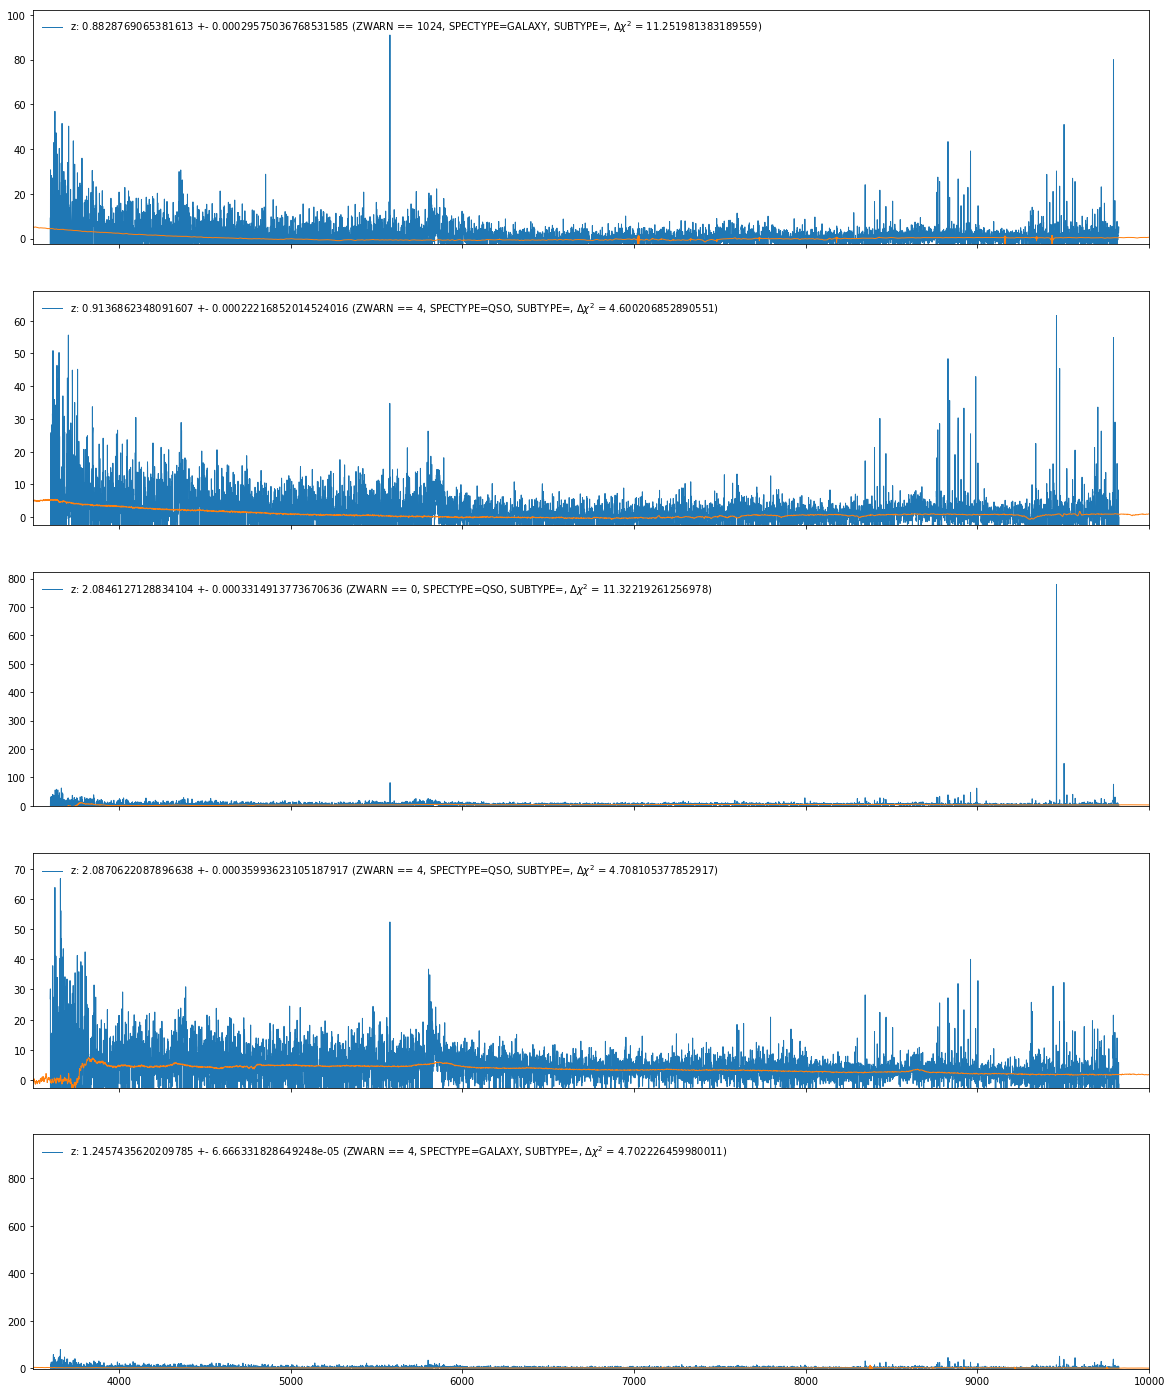

In [232]:
for i, (night, tile) in enumerate(samples):
    nspec     = 5
    fig, axes = plt.subplots(nspec, figsize=(20, nspec * 5))

    zbests    = results[tile][night]['zbests']
    cfluxs    = results[tile][night]['coadds_flux']
    
    # best    = np.argsort(zbest['DELTACHI2'])[::-1]
    # isin    = bgs_azbests['DELTACHI2'][best] < 100.
    
    for i in range(nspec):
      #  [best][isin]
      bestfit_compare(i, axes[i], zbests, cfluxs)
        
    for ax in fig.get_axes():
        ax.label_outer()
        
    break

##  Match to G12

In [57]:
# Matching
def matches(bgs_acoadds, spec, _RA='RA', _DEC='DEC'):
  c              = SkyCoord(ra=bgs_acoadds['TARGET_RA']*u.degree, dec=bgs_acoadds['TARGET_DEC']*u.degree)
  catalog        = SkyCoord(ra=spec[_RA]*u.degree, dec=spec[_DEC]*u.degree)

  idx, d2d, d3d  = c.match_to_catalog_sky(catalog)

  max_sep        = 1.0 * u.arcsec

  sep_constraint = d2d < max_sep

  c              = c[sep_constraint]

  _matches       = catalog[idx[sep_constraint]]

  coadd_matches  = bgs_acoadds[sep_constraint]
  flux_matches   = bgs_acoadds_flux[sep_constraint]
  mask_matches   = bgs_acoadds_mask[sep_constraint]
  zbest_matches  = bgs_azbests[sep_constraint] 
  spec_matches   =     spec[idx[sep_constraint]]
    
  return  coadd_matches, zbest_matches, spec_matches, flux_matches, mask_matches

In [188]:
gcoadd_matches, gzbest_matches, gama_matches, gflux_matches, gmask_matches =  matches(bgs_acoadds, G12)

In [59]:
# Sanity check
# dra, ddec      = c.spherical_offsets_to(_matches)

In [60]:
#dra.arcsec, ddec.arcsec

In [61]:
len(gama_matches)

418

Text(0,0.5,'rr $z$')

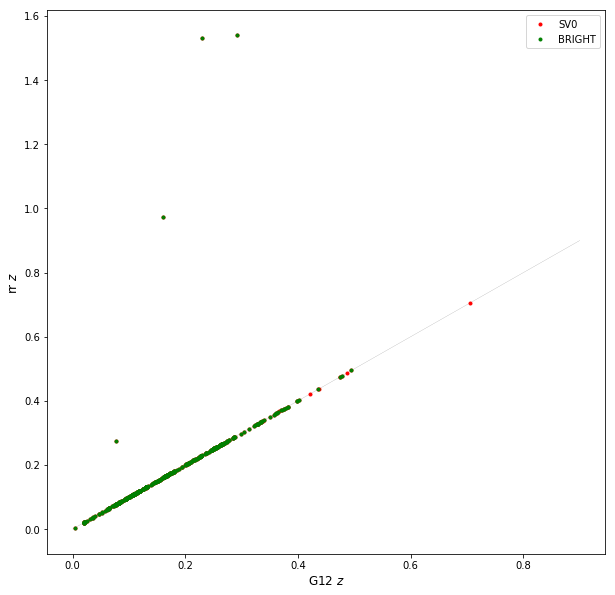

In [62]:
plt.rcParams['figure.figsize'] = [10, 10]

_ = np.arange(0.0, 1.0, 0.1)

pl.plot(_, _, 'k-', lw=0.1)

pl.plot(gama_matches['Z'][gzbest_matches['IS_SV0'] == True],        gzbest_matches['Z'][gzbest_matches['IS_SV0'] == True], '.', c='r', label='SV0')
pl.plot(gama_matches['Z'][gzbest_matches['IS_MSV_BRIGHT'] == True], gzbest_matches['Z'][gzbest_matches['IS_MSV_BRIGHT'] == True], '.', c='g', label='BRIGHT')

pl.legend(loc=1)

pl.xlabel('G12 $z$', fontsize=12)
pl.ylabel('rr $z$', fontsize=12) 

In [155]:
list(gzbest_matches['TARGETID'][gzbest_matches['Z'] > 0.8])

[35185754749537153, 35185760747391658, 35185760747392924]

In [190]:
list(gzbest_matches['TARGETID'][(gzbest_matches['Z'] > 0.2) & (gama_matches['Z'] < 0.1)])

[35185766787188134]

##  Match to SDSS

In [63]:
# Table(SDSS)

In [109]:
scoadd_matches, szbest_matches, sdss_matches, sflux_matches, smask_matches =  matches(bgs_acoadds, SDSS, _RA='PLUG_RA', _DEC='PLUG_DEC')

Text(0,0.5,'rr $z$')

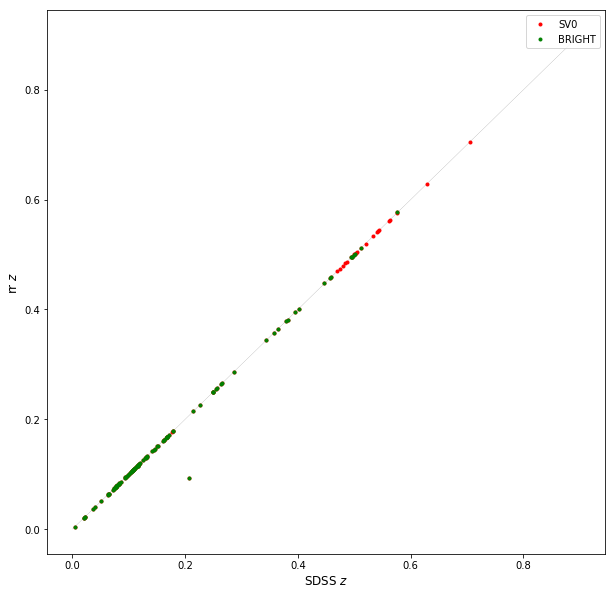

In [65]:
plt.rcParams['figure.figsize'] = [10, 10]

_              = np.arange(0.0, 1.0, 0.1)

pl.plot(_, _, 'k-', lw=0.1)

pl.plot(sdss_matches['Z'][szbest_matches['IS_SV0'] == True],        szbest_matches['Z'][szbest_matches['IS_SV0'] == True], '.', c='r', label='SV0')
pl.plot(sdss_matches['Z'][szbest_matches['IS_MSV_BRIGHT'] == True], szbest_matches['Z'][szbest_matches['IS_MSV_BRIGHT'] == True], '.', c='g', label='BRIGHT')

pl.legend(loc=1)

pl.xlabel('SDSS $z$', fontsize=12)
pl.ylabel('rr $z$', fontsize=12)

In [111]:
sample = szbest_matches[(sdss_matches['Z'] > 0.20) & (sdss_matches['Z'] < 2.2)]
sample.sort('Z')
sample

TARGETID,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,NUMEXP,NUMTILE,IS_SV0,IS_MSV_BRIGHT
int64,float64,float64,float64,float64,int64,int64,bytes6,bytes20,int64,float64,int32,int32,bool,bool
35185754749535144,25608.05457019806,27689.78649571924 .. 976.5187011466222,0.09354795482268664,6.4447989195254015e-06,0,7745,GALAXY,,10,101947.19459552318,0,0,True,True
35185760785139023,10167.754521280527,1356.0074362439996 .. 54.903478622651726,0.21427653655571383,2.6609961854788595e-05,0,7749,GALAXY,,10,3196.3111872300506,0,0,True,True
35185754715982156,12251.662976928055,2224.0365307620355 .. 17.432314950228196,0.22612346275745993,2.8380769932761653e-05,0,7757,GALAXY,,10,4072.065252647735,0,0,True,True
35185754741147993,13018.548630028963,2627.583466973857 .. 34.53669936412781,0.24901660214438867,2.713258059218603e-05,0,7748,GALAXY,,10,6772.701130170375,0,0,True,True
35185760747388948,11113.573589865118,957.6811491729397 .. -10.04079990219625,0.2490951267757444,6.103664058350794e-05,0,7739,GALAXY,,10,238.33237057551742,0,0,True,True
35185730581957831,12396.36006963253,2313.820783295135 .. 32.41506000052852,0.24973059162805303,2.880891879652917e-05,0,7751,GALAXY,,10,6081.801864087582,0,0,True,True
35185730573566760,10390.343407988548,1646.5160883211129 .. 50.56911178500406,0.2544896945127729,1.2135539747286233e-05,0,7754,GALAXY,,10,3586.9091157708317,0,0,True,True
35185772860542936,13782.653837628663,2675.8748890059283 .. 8.77986370060807,0.25717148797514156,3.465647408161448e-05,0,7757,GALAXY,,10,4834.444494180381,0,0,True,True
35185736613365164,10654.60420332849,1974.6471923388972 .. -11.672376657655612,0.2635215817593905,3.631901271021058e-05,0,7756,GALAXY,,10,3945.640253469348,0,0,True,True


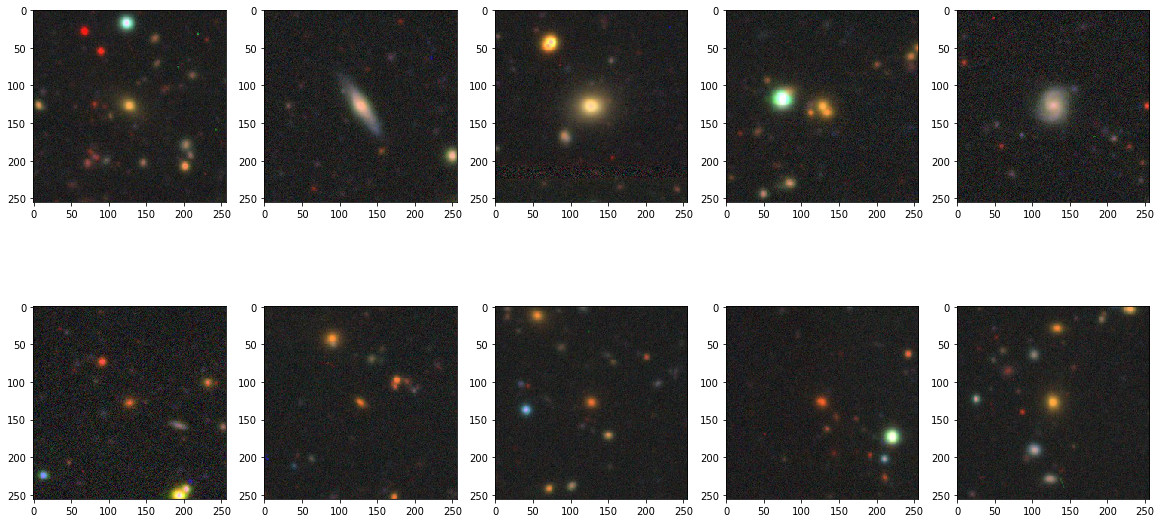

In [66]:
get_dr7cutout(scoadd_matches['TARGET_RA'][0:10], scoadd_matches['TARGET_DEC'][0:10])

In [100]:
##  len(sdss_matches)

In [68]:
##  os.system('http://legacysurvey.org/viewer/cutout.fits?ra=186.3882&dec=12.2592&layer=dr8&pixscale=1.00']

In [69]:
##  Table(sdss_matches)

##  SDSS spectra for comparison (rr z > 1.0)

In [70]:
def get_sdss_spectra(sdss_matches):
  waves  = []
  bspecs = []
  bmasks = []

  for survey, plate, mjd, fiber in zip(sdss_matches['SURVEY'], sdss_matches['PLATE'], sdss_matches['MJD'], sdss_matches['FIBERID']):    
    survey     = survey.decode('utf-8').strip()
    exists     = False
 
    wave       = None
    bspec      = None
    
    # print('Finding {} {} {} {}'.format(survey, plate, mjd, fiber))

    for _ in ['v5_10_0', '103', '104', '26']:
      fpath    = '/project/projectdirs/cosmo/data/sdss/dr14/{}/spectro/redux/{}/spectra/{:04d}/spec-{:04d}-{}-{:04d}.fits'.format(survey, _, plate, plate, mjd,fiber)
    
      try:      
        bspec  = fitsio.read(fpath)    
        exists = True

        wave   = 10. ** bspec['loglam']
        bmask  = np.clip(bspec['and_mask'].astype(np.float), a_max=1.0, a_min=0.0)
        bspec  = bspec['flux']
            
        waves.append(wave)
        bspecs.append(bspec) 
        bmasks.append(bmask)
        
      except:            
        continue
    
      # print('Found.')

      break

    if exists == False:
      waves.append(None)
      bspecs.append(None) 
      bmasks.append(None)
        
  return  waves, bspecs, bmasks

In [71]:
sdss_matches.shape

(129,)

In [72]:
sdss_waves, sdss_bspecs, sdss_bmasks = get_sdss_spectra(sdss_matches)

In [73]:
len(sdss_waves)

129

In [74]:
# sdss_bmasks

In [76]:
len(sdss_waves), len(sdss_bspecs)

(129, 129)

In [149]:
def sdss_compare(i, plotted, ax, zbests, coadds_flux, coadds, sdss_wave, sdss_flux, spec_matches, plot_sdss=True, plot_redrock=True, plot_desi=False, btids=[]):
    zbest    = Table(zbests)[i]

    z        = zbest['Z']
    zerr     = zbest['ZERR']
    dchi2    = zbest['DELTACHI2']
    zwarn    = zbest['ZWARN']
    targetid = zbest['TARGETID']
    spectype = zbest['SPECTYPE'].strip()
    subtype  = zbest['SUBTYPE'].strip()

    fulltype = (spectype, subtype)

    ncoeff   = templates[fulltype].flux.shape[0]
    coeff    = zbest['COEFF'][0:ncoeff]

    tflux    = templates[fulltype].flux.T.dot(coeff)
    twave    = templates[fulltype].wave * (1. + z)

    if (len(btids) > 0) & (targetid not in btids):
      return  plotted
        
    if sdss_wave[i] is not None:
      if plot_sdss:
        ax.plot(sdss_wave[i], sdss_flux[i], label='SDSS: {}; z: {} +- {};  Petal {}; Device Loc. {}.'.format(zbests['TARGETID'][i], spec_matches['Z'][i], spec_matches['Z_ERR'][i], coadds['PETAL_LOC'][i], coadds['DEVICE_LOC'][i]))

      if plot_desi:
        if targetid in btids:
          ax.plot(wave, coadds_flux[i,:], lw=1.0, label='{}, z: {} +- {} (ZWARN == {}, SPECTYPE={}, SUBTYPE={}, $\Delta \chi^2$ = {})'.format(zbests['TARGETID'][i], z, zerr, zwarn, spectype, subtype, dchi2), c='r')
            
        else:
          ax.plot(wave, coadds_flux[i,:], lw=1.0, label='{}, z: {} +- {} (ZWARN == {}, SPECTYPE={}, SUBTYPE={}, $\Delta \chi^2$ = {})'.format(zbests['TARGETID'][i], z, zerr, zwarn, spectype, subtype, dchi2), c='k')
    
      if plot_redrock:
        ax.plot(sdss_wave[i], resample_flux(sdss_wave[i], twave, tflux), lw=1.0, c='gold', label='redrock')

      plotted += 1
        
      ax.legend(loc=2, frameon=False)
    
    return  plotted

##  Bad SDSS target. 

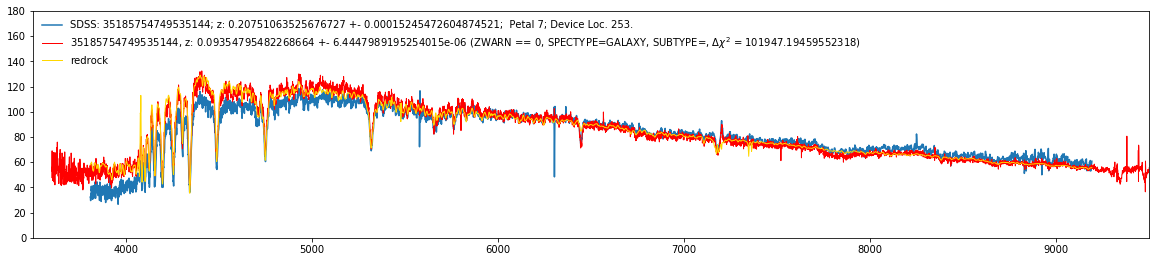

In [153]:
nspec       = 129
fig, axes   = plt.subplots(nspec, figsize=(20, 5 * nspec))

plotted     = 0

btids       = [35185754749535144]

for i in range(nspec):
  tid       = szbest_matches['TARGETID'][i]

  plotted   = sdss_compare(i, plotted, axes[plotted], szbest_matches, sflux_matches, scoadd_matches, sdss_waves, sdss_bspecs,sdss_matches, \
                           plot_redrock=True, plot_sdss=True, plot_desi=True, btids=btids)  
    
for i, ax in enumerate(fig.get_axes()):
    ax.set_xlim(3500., 9500.)    
    ax.set_ylim(0., 180.)
    
    if i >= plotted:
        ax.remove()
    
plt.savefig('bad_sdssid.pdf')

In [263]:
def gama_compare(i, plotted, ax, zbests, coadds_flux, coadds, spec_matches, plot_redrock=True, plot_desi=False, btids=[], gmags=None, rmags=None, zmags=None):
    zbest    = Table(zbests)[i]

    z        = zbest['Z']
    zerr     = zbest['ZERR']
    dchi2    = zbest['DELTACHI2']
    zwarn    = zbest['ZWARN']
    targetid = zbest['TARGETID']
    spectype = zbest['SPECTYPE'].strip()
    subtype  = zbest['SUBTYPE'].strip()

    fulltype = (spectype, subtype)

    ncoeff   = templates[fulltype].flux.shape[0]
    coeff    = zbest['COEFF'][0:ncoeff]

    tflux    = templates[fulltype].flux.T.dot(coeff)
    twave    = templates[fulltype].wave * (1. + z)

    if (len(btids) > 0) & (targetid not in btids):
      return  plotted

    if plot_desi:  
      ax.plot(wave, coadds_flux[i,:], lw=1.0, label='{}, z: {} +- {} (ZWARN == {}, SPECTYPE={}, SUBTYPE={}, $\Delta \chi^2$ = {}, $grz$:  {:.1f}, {:.1f}, {:.1f})'.format(zbests['TARGETID'][i], z, zerr, zwarn, spectype, subtype, dchi2, gmags[plotted], rmags[plotted], zmags[plotted]), c='r')
            
    if plot_redrock:
      ax.plot(wave, resample_flux(wave, twave, tflux), lw=1.0, c='gold', label='redrock.')

    ax.set_title('BAD GAMA Z: {}'.format(spec_matches['Z'][i]))
    
    plotted += 1
        
    ax.legend(loc=2, frameon=False)
    
    return  plotted

##  BAD GAMA targets.

In [259]:
btids          = [35185754749537153, 35185760747391658, 35185760747392924, 35185766787188134]

isin           = [x in btids for x in gzbest_matches['TARGETID']]

gzbest_matches =  gzbest_matches[isin]
gflux_matches  =  gflux_matches[isin]
gcoadd_matches =  gcoadd_matches[isin]

In [264]:
def flux2mag(flux) :
    mag = -2.5*np.log10(flux*(flux>0) + 0.001*(flux<=0)) + 22.5
    mag[(flux<=0)] = 0.
    return mag

In [261]:
gcoadd_matches

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,PMRA_IVAR,PMDEC_IVAR,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,NUMTARGET,PRIORITY,SUBPRIORITY,OBSCONDITIONS,NUMOBS_MORE,RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,TARGET_RA_IVAR,TARGET_DEC_IVAR,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,WISEMASK_W1,WISEMASK_W2,MASKBITS,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEDEV_R_IVAR,SHAPEDEV_E1_IVAR,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SHAPEEXP_R_IVAR,SHAPEEXP_E1_IVAR,SHAPEEXP_E2_IVAR,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PHOTSYS,CMX_TARGET,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL,BLOBDIST,FIBERFLUX_IVAR_G,FIBERFLUX_IVAR_R,FIBERFLUX_IVAR_Z,DESI_TARGET,BGS_TARGET,MWS_TARGET,NUM_ITER,FIBER_X,FIBER_Y,MEAN_DELTA_X,MEAN_DELTA_Y,FIBER_RA,FIBER_DEC,RMS_DELTA_X,RMS_DELTA_Y,FIRST_FIBER,LAST_FIBER,NUM_FIBER,IS_SV0,IS_MSV_BRIGHT
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int16,int32,float64,int32,int32,int16,int32,bytes8,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,bool,float32,float32,bytes1,int64,int64,int64,int64,float32,float32,float32,float32,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bool,bool
35185754749537153,7,268,7268,3690,0,181.09292806113913,-0.21457102348844811,0.0,0.0,0.0,0.0,0.0,5400.0,72057594037928192,1,TGT,-271.40018,70.86236,0,5000,0.3853929999982686,65535,99,8000,329652,1811m002,2945,EXP,1316156600000.0,750977200000.0,0.026242942,12.212502,23.246504,37.72846,319.69922,101.143654,26.61857,0.9252564,0.94901615,0.9711536,0.0013676116,0.0018066406,0.0009811564,0.0024745765,0.0034537811,0.005640704,0.9994078,0.9994584,0.9993413,4,3,3,1841.7732,423.33423,115.57883,1122.6482,289.29083,67.35383,47.338852,41.77307,278.3981,1801.1212,2.1695795,0.3746788,0.0006359402,8.8265415e-06,0.9955625,0.99727243,0.99941766,0.99978006,0,0,0,3.253891,6.1937833,10.052347,3.253891,6.1937833,10.052347,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.6447543,0.25001907,0.44605547,27795.75,74924.05,88324.77,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0.0,True,0.0,0.0,S,72057594037928192,2101,1,26282,0.0,0.0,0.0,0.0,0,0,0,3,-271.131,70.798,-0.0018333333333333333,0.0033333333333333335,0.0,0.0,0.006493586579592719,0.0049328828623162475,3690,3690,1,True,True
35185760747391658,3,505,3505,1787,0,178.50740490736084,-0.00815008510941419,0.0,0.0,0.0,0.0,0.0,5400.0,72057594037928192,1,TGT,378.16235,124.581856,0,5000,0.29914765278946

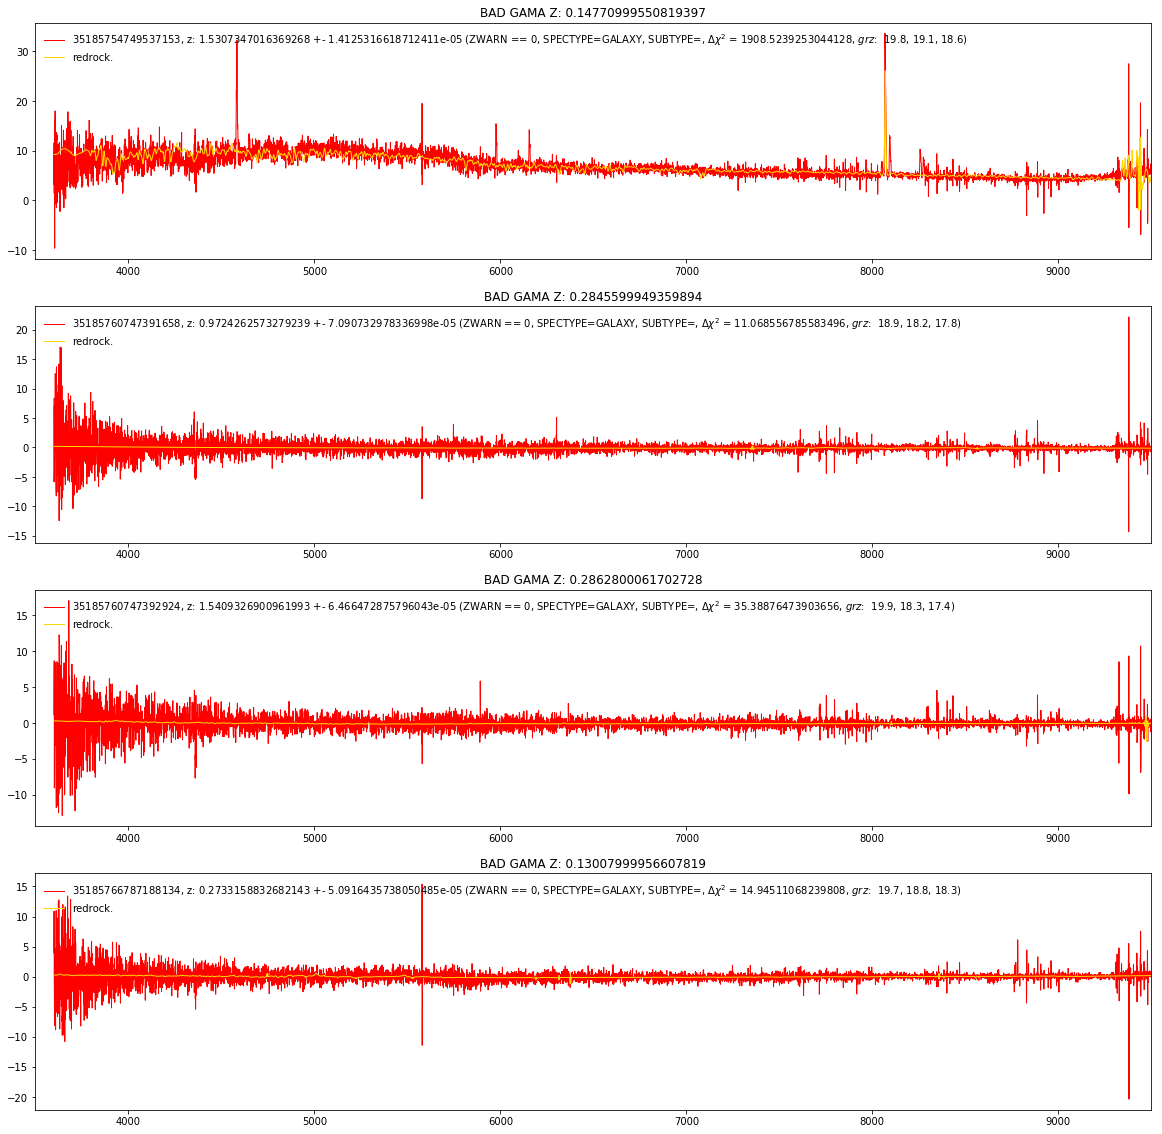

In [266]:
nspec       = 4
fig, axes   = plt.subplots(nspec, figsize=(20, 20))

plotted     = 0

gmags, rmags, zmags = flux2mag(gcoadd_matches['FLUX_G']), flux2mag(gcoadd_matches['FLUX_R']), flux2mag(gcoadd_matches['FLUX_Z'])

for i in range(nspec):
  tid       = gzbest_matches['TARGETID'][i]

  plotted   = gama_compare(i, plotted, axes[plotted], gzbest_matches, gflux_matches, gcoadd_matches, gama_matches,\
                           plot_redrock=True, plot_desi=True, btids=btids, gmags=gmags, rmags=rmags, zmags=zmags)  
    
for i, ax in enumerate(fig.get_axes()):
    ax.set_xlim(3500., 9500.)    
    # ax.set_ylim(-20., 50.)
    
    if i >= plotted:
        ax.remove()
    
plt.savefig('bad_gamaid.pdf')

In [221]:
def band_fluxes(wave, flux, dmask, wmin=3802., wmax=9212.):
    dwave = np.gradient(wave)
    
    bmask = ((wave < bandpasses['b'][0]) | (wave > bandpasses['b'][1])) & dmask.astype(bool) & (wave < wmin) & (wave > wmax)
    rmask = ((wave < bandpasses['r'][0]) | (wave > bandpasses['r'][1])) & dmask.astype(bool) & (wave < wmin) & (wave > wmax)
    zmask = ((wave < bandpasses['z'][0]) | (wave > bandpasses['z'][1])) & dmask.astype(bool) & (wave < wmin) & (wave > wmax)
    
    # print(np.count_nonzero(bmask))
        
    return  np.sum(flux[~bmask] * dwave[~bmask]), np.sum(flux[~rmask] * dwave[~rmask]), np.sum(flux[~zmask] * dwave[~zmask])

In [80]:
sbandpass_fluxes = [] 

for i, _ in enumerate(sdss_waves):
    if _ is not None:
      b,r,z = band_fluxes(sdss_waves[i], sdss_bspecs[i], sdss_bmasks[i])
    
      sbandpass_fluxes.append([b, r, z])
        
    else:
      sbandpass_fluxes.append([-99., -99., -99.])
        
sbandpass_fluxes = np.array(sbandpass_fluxes)

In [81]:
bandpass_fluxes = [] 

for i, _ in enumerate(sflux_matches):
    if _ is not None:
      b,r,z = band_fluxes(wave, sflux_matches[i], smask_matches[i])
    
      bandpass_fluxes.append([b, r, z])
        
    else:
      bandpass_fluxes.append([-99., -99., -99.])
        
bandpass_fluxes = np.array(bandpass_fluxes)

In [82]:
# sdss_waves[0].min(), sdss_waves[0].max(), wave.min(), wave.max()

In [83]:
# bandpass_fluxes
# sbandpass_fluxes

Text(0,0.5,'DESI integrated band flux')

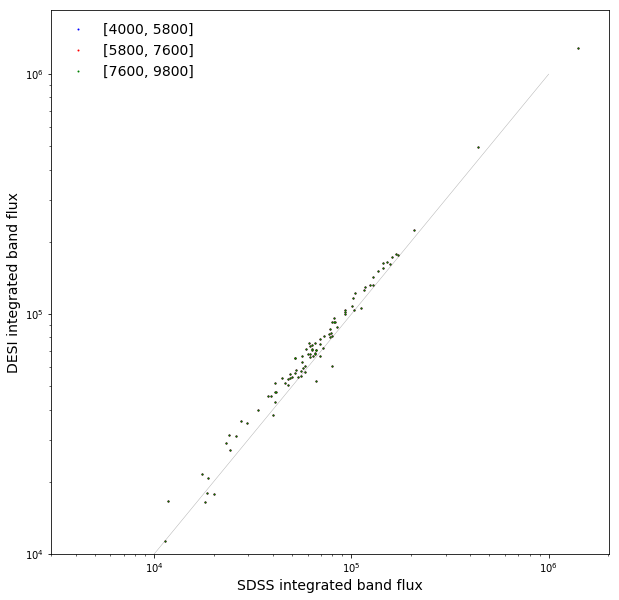

In [84]:
plt.rcParams['figure.figsize'] = [10, 10]

_ = np.logspace(3, 6, 100)

pl.loglog(_, _, c='k', alpha=0.3, lw=0.5)

pl.loglog(sbandpass_fluxes[:,0], bandpass_fluxes[:,0], marker='.', lw=0, c='b', markersize=2, label='[4000, 5800]')
pl.loglog(sbandpass_fluxes[:,1], bandpass_fluxes[:,1], marker='.', lw=0, c='r', markersize=2, label='[5800, 7600]')
pl.loglog(sbandpass_fluxes[:,2], bandpass_fluxes[:,2], marker='.', lw=0, c='g', markersize=2, label='[7600, 9800]')

pl.xlim(left=3.e3)
pl.ylim(bottom=1.e4)

pl.legend(loc=2, frameon=False, fontsize=14)

pl.xlabel('SDSS integrated band flux', fontsize=14)
pl.ylabel('DESI integrated band flux', fontsize=14)

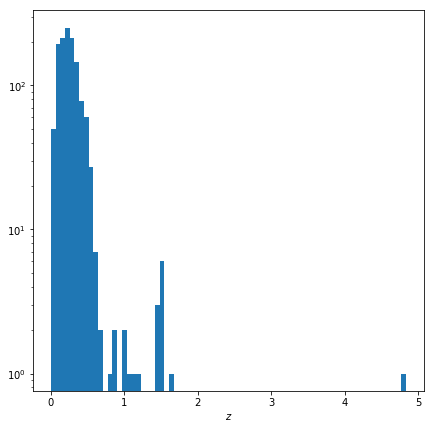

In [85]:
plt.rcParams['figure.figsize'] = [7, 7]

_ = pl.hist(bgs_azbests['Z'], bins=75)

pl.xlabel(r'$z$')
pl.yscale('log')

In [86]:
def sdss_compare_lines(i, j, plotted, ax, line, name, zbests, coadds_flux, coadds, sdss_wave, sdss_flux, plot_sdss=True, plot_redrock=True, plot_desi=False, yscale=False):
    zbest    = Table(zbests)[i]

    z        = zbest['Z']
    zerr     = zbest['ZERR']
    dchi2    = zbest['DELTACHI2']
    zwarn    = zbest['ZWARN']
    targetid = zbest['TARGETID']
    spectype = zbest['SPECTYPE'].strip()
    subtype  = zbest['SUBTYPE'].strip()

    fulltype = (spectype, subtype)

    line    *= (1. + z)
    
    ncoeff   = templates[fulltype].flux.shape[0]
    coeff    = zbest['COEFF'][0:ncoeff]

    tflux    = templates[fulltype].flux.T.dot(coeff)
    twave    = templates[fulltype].wave * (1. + z)
    
    if sdss_wave[i] is not None:
      norm   = np.mean(resample_flux(sdss_wave[i], twave, tflux)[(sdss_wave[i] > 0.95 * line) & (sdss_wave[i] < 1.05 * line)] )
  
      if plot_sdss:
        toplot = sdss_flux[i]
        ax.plot(sdss_wave[i], toplot, label='{}; Petal {}; Device Loc. {}.'.format(zbests['TARGETID'][i], coadds['PETAL_LOC'][i], coadds['DEVICE_LOC'][i]))
    
      if plot_desi:
        toplot = coadds_flux[i,:]
        ax.plot(wave, toplot, lw=1.0, label='{}'.format(zbests['TARGETID'][i]), c='k')
    
      if plot_redrock:            
        toplot = resample_flux(sdss_wave[i], twave, tflux)
        ax.plot(sdss_wave[i], toplot, lw=1.0, c='gold', label='redrock')

      if j == 0:
        plotted += 1
        
      ax.legend(loc=2, frameon=False)
    
      # ax.axhline(y=norm, xmin=0., xmax=1., c='w', lw=4)

      if yscale:
        try:
          ax.set_ylim(0.05 * norm, 2.50 * norm)
 
        except:
          print('Failed to scale to {}'.format(norm))
        
      ax.set_xlim(0.95 * line, 1.05 * line)
      ax.set_title(name)
    
    return  plotted

##  Emission lines 

##  Absorption lines

##  Done.